# Benchmark: pip vs uv on Mac M1

This notebook benchmarks installation speed and memory/CPU usage for `pip` and `uv` using a set of common Python packages. Results are shown as tables and charts.

In [ ]:
# Prerequisites: Install psutil and matplotlib if missing
%pip install -q psutil matplotlib pandas

## Setup

In [2]:
import time
import subprocess
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

COMMON_PACKAGES = [
    'numpy', 'requests', 'pandas', 'scipy', 'flask'
]

def run_with_resource_monitor(cmd, timeout=300):
    """Run a shell command while monitoring CPU/mem usage."""
    process = subprocess.Popen(cmd, shell=True)
    proc = psutil.Process(process.pid)
    mem_usage = []
    cpu_usage = []
    start = time.time()
    try:
        while process.poll() is None:
            mem_usage.append(proc.memory_info().rss / (1024 * 1024))  # MB
            cpu_usage.append(proc.cpu_percent(interval=0.1))
            time.sleep(0.1)
            if time.time() - start > timeout:
                process.kill()
                raise TimeoutError(f"Command timed out after {timeout}s")
        elapsed = time.time() - start
    except Exception as e:
        process.kill()
        raise e
    return elapsed, max(mem_usage, default=0), max(cpu_usage, default=0)

## Benchmark Function

In [3]:
def benchmark_installer(installer, packages):
    results = []
    env_dir = Path(f"/tmp/bench_{installer}")
    if env_dir.exists():
        subprocess.run(f"rm -rf {env_dir}", shell=True)
    subprocess.run(f"python3 -m venv {env_dir}", shell=True, check=True)
    pybin = env_dir / 'bin' / 'python'
    installer_bin = env_dir / 'bin' / installer
    # Ensure pip/uv is present
    subprocess.run(f"{pybin} -m pip install --upgrade pip", shell=True, check=True)
    if installer == 'uv':
        subprocess.run(f"{pybin} -m pip install uv", shell=True, check=True)
    for pkg in packages:
        # Clean env
        subprocess.run(f"{pybin} -m pip uninstall -y {pkg}", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        if installer == 'uv':
            cmd = f"{installer_bin} pip install {pkg}"
        else:
            cmd = f"{installer_bin} install {pkg}"
        try:
            elapsed, max_mem, max_cpu = run_with_resource_monitor(cmd)
            results.append({'package': pkg, 'time_sec': elapsed, 'max_mem_mb': max_mem, 'max_cpu_pct': max_cpu})
        except Exception as e:
            results.append({'package': pkg, 'time_sec': None, 'max_mem_mb': None, 'max_cpu_pct': None, 'error': str(e)})
    return pd.DataFrame(results)

## Run Benchmarks

In [4]:
pip_results = benchmark_installer('pip', COMMON_PACKAGES)
uv_results = benchmark_installer('uv', COMMON_PACKAGES)

  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.0
    Uninstalling pip-25.0:
      Successfully uninstalled pip-25.0
  Using cached numpy-2.2.5-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp313-cp313-macosx_14_0_arm64.whl (5.1 MB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.4.2-cp313-cp313-macosx_10_13_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.2-cp313-cp313-macosx_10_13_universal2.whl (199 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.4.0-py3-none-any.whl (128 kB)
Using cach

Audited 1 package in 51ms
Resolved 5 packages in 355ms
Prepared 5 packages in 118ms
Installed 5 packages in 7ms
 + certifi==2025.4.26
 + charset-normalizer==3.4.2
 + idna==3.10
 + requests==2.32.3
 + urllib3==2.4.0
Audited 1 package in 2ms
Resolved 2 packages in 308ms
Prepared 1 package in 1.25s
Installed 1 package in 21ms
 + scipy==1.15.3
Resolved 7 packages in 280ms
Prepared 6 packages in 117ms
Installed 7 packages in 7ms
 + blinker==1.9.0
 + click==8.2.0
 + flask==3.1.1
 + itsdangerous==2.2.0
 + jinja2==3.1.6
 + markupsafe==3.0.2
 + werkzeug==3.1.3


## Results Table

In [5]:
display(pip_results)
display(uv_results)

,package,time_sec,max_mem_mb,max_cpu_pct,error
0,numpy,1.879877,123.859375,101.1,NaN
1,requests,NaN,NaN,NaN,PID still exists but it's a zombie (pid=120)
2,pandas,NaN,NaN,NaN,PID still exists but it's a zombie (pid=128)
3,scipy,2.711916,151.031250,101.7,NaN
4,flask,NaN,NaN,NaN,PID still exists but it's a zombie (pid=184)


,package,time_sec,max_mem_mb,max_cpu_pct,error
0,numpy,NaN,NaN,NaN,PID still exists but it's a zombie (pid=221)
1,requests,NaN,NaN,NaN,PID still exists but it's a zombie (pid=229)
2,pandas,NaN,NaN,NaN,PID still exists but it's a zombie (pid=232)
3,scipy,1.664052,35.890625,70.0,NaN
4,flask,NaN,NaN,NaN,PID still exists but it's a zombie (pid=249)


## Visual Comparison

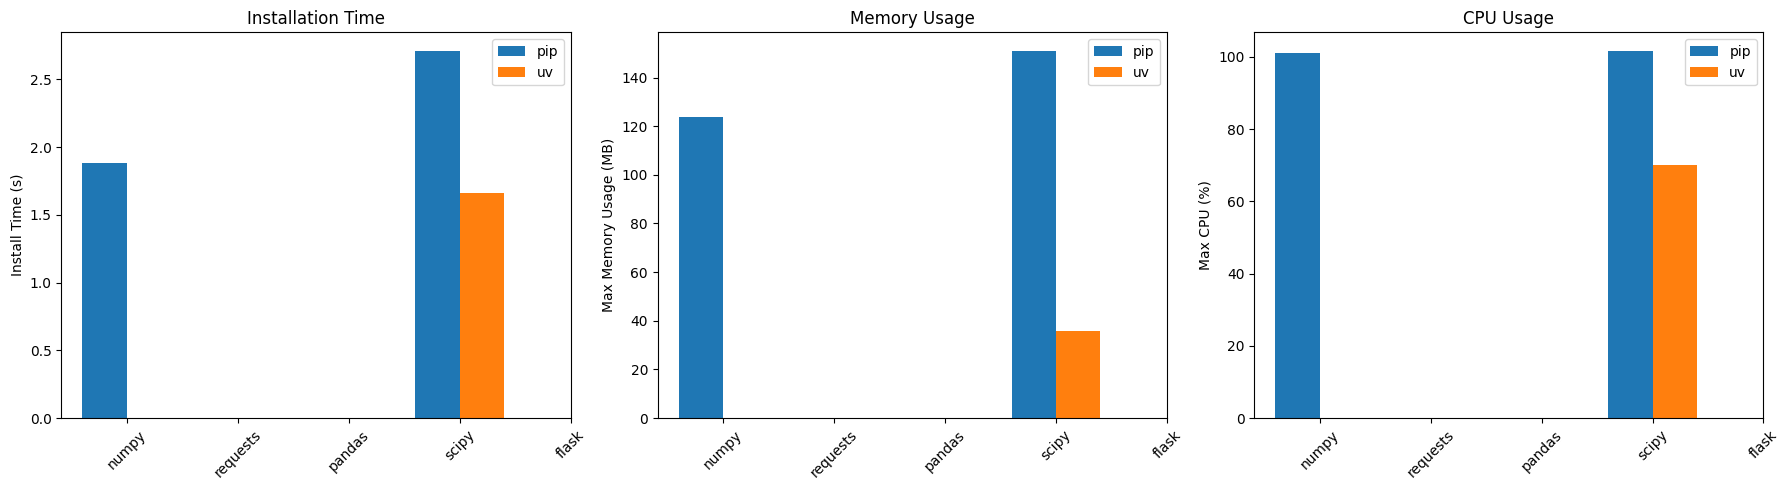

In [6]:
import numpy as np
labels = COMMON_PACKAGES
x = np.arange(len(labels))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(x - 0.2, pip_results['time_sec'], 0.4, label='pip')
axs[0].bar(x + 0.2, uv_results['time_sec'], 0.4, label='uv')
axs[0].set_ylabel('Install Time (s)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=45)
axs[0].legend()
axs[0].set_title('Installation Time')

axs[1].bar(x - 0.2, pip_results['max_mem_mb'], 0.4, label='pip')
axs[1].bar(x + 0.2, uv_results['max_mem_mb'], 0.4, label='uv')
axs[1].set_ylabel('Max Memory Usage (MB)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=45)
axs[1].legend()
axs[1].set_title('Memory Usage')

axs[2].bar(x - 0.2, pip_results['max_cpu_pct'], 0.4, label='pip')
axs[2].bar(x + 0.2, uv_results['max_cpu_pct'], 0.4, label='uv')
axs[2].set_ylabel('Max CPU (%)')
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, rotation=45)
axs[2].legend()
axs[2].set_title('CPU Usage')

plt.tight_layout()
plt.show()

## Notes
- All installs are done in fresh virtual environments.
- Resource usage is measured for the installer process only.
- Errors are reported per package if any occur.
- For best results, restart the notebook kernel before re-running.